In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL
from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError
import os.path
import os
import cv2
import itertools
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import datetime
import zipfile
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import img_to_array
import datetime
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_augmented_images(generator, save_dir, num_batches=10):
    for i, (x_batch, y_batch) in enumerate(generator):
        if i >= num_batches:
            break
        for j, (img_array, label) in enumerate(zip(x_batch, y_batch)):
            img = array_to_img(img_array)
            img.save(os.path.join(save_dir, f"img_{i}_{j}.png"))


def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [3]:
dataset = "../input/building-health"
walk_through_dir(dataset)

There are 2 directories and 0 images in '../input/building-health'.
There are 0 directories and 41 images in '../input/building-health/Healthy'.
There are 0 directories and 57 images in '../input/building-health/Unhealthy'.


In [4]:
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("../input/building-health").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [6]:
image_df.shape

(98, 2)

# EDA

## Images Feature Extraction:

You could use OpenCV to extract color features or other image properties.

- The image is then converted from the BGR color space to the HSV color space. HSV is preferred here since it can be more robust to variations in lighting and is often used for color-based segmentation.
- Two specific color ranges are defined for violet and yellow. The values used for these color ranges might need to be adjusted depending on the exact shades and variations of violet and yellow in your images.

In [7]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    # resized_image = cv2.resize(image, (224, 224))
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    violet_lower = np.array([120, 50, 50])
    violet_upper = np.array([160, 255, 255])
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    # Create masks
    violet_mask = cv2.inRange(hsv, violet_lower, violet_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    
    # Compute feature as fraction of pixels in each color
    total_pixels = image.shape[0] * image.shape[1]
    violet_fraction = np.sum(violet_mask) / total_pixels
    yellow_fraction = np.sum(yellow_mask) / total_pixels
    
    return violet_fraction, yellow_fraction

In [8]:
violet_fractions = []
yellow_fractions = []

for path in filepaths:
    violet_fraction, yellow_fraction = extract_features(path)
    violet_fractions.append(violet_fraction)
    yellow_fractions.append(yellow_fraction)
image_df['Violet_Fraction'] = violet_fractions
image_df['Yellow_Fraction'] = yellow_fractions

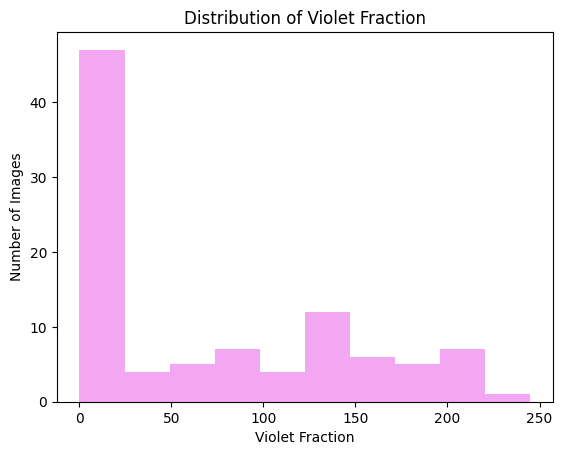

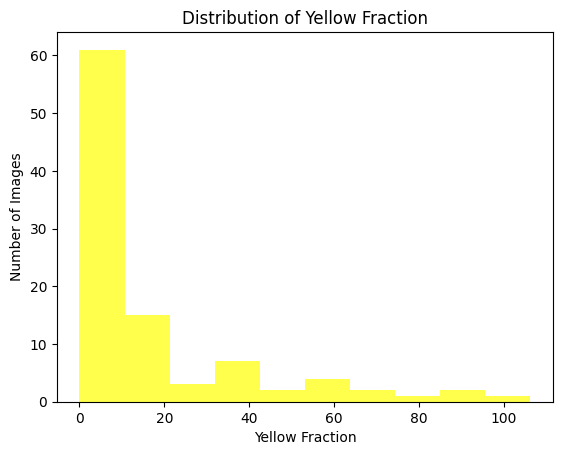

In [10]:
plt.hist(image_df['Violet_Fraction'],  color='violet', alpha=0.7)
plt.title('Distribution of Violet Fraction')
plt.xlabel('Violet Fraction')
plt.ylabel('Number of Images')
plt.show()

plt.hist(image_df['Yellow_Fraction'], color='yellow', alpha=0.7)
plt.title('Distribution of Yellow Fraction')
plt.xlabel('Yellow Fraction')
plt.ylabel('Number of Images')
plt.show()


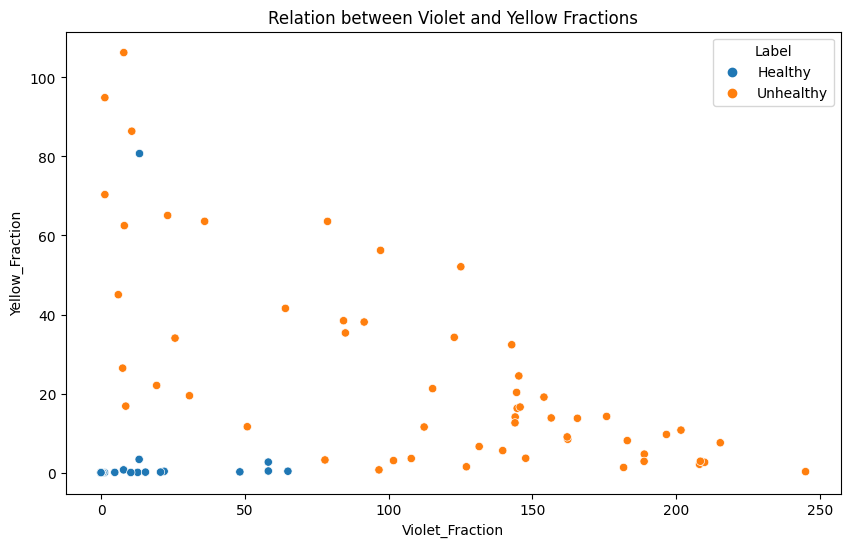

In [11]:
# Scatter plot to see the relation between Violet_Fraction and Yellow_Fraction
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Violet_Fraction', y='Yellow_Fraction', hue='Label', data=image_df)
plt.title('Relation between Violet and Yellow Fractions')
plt.show()

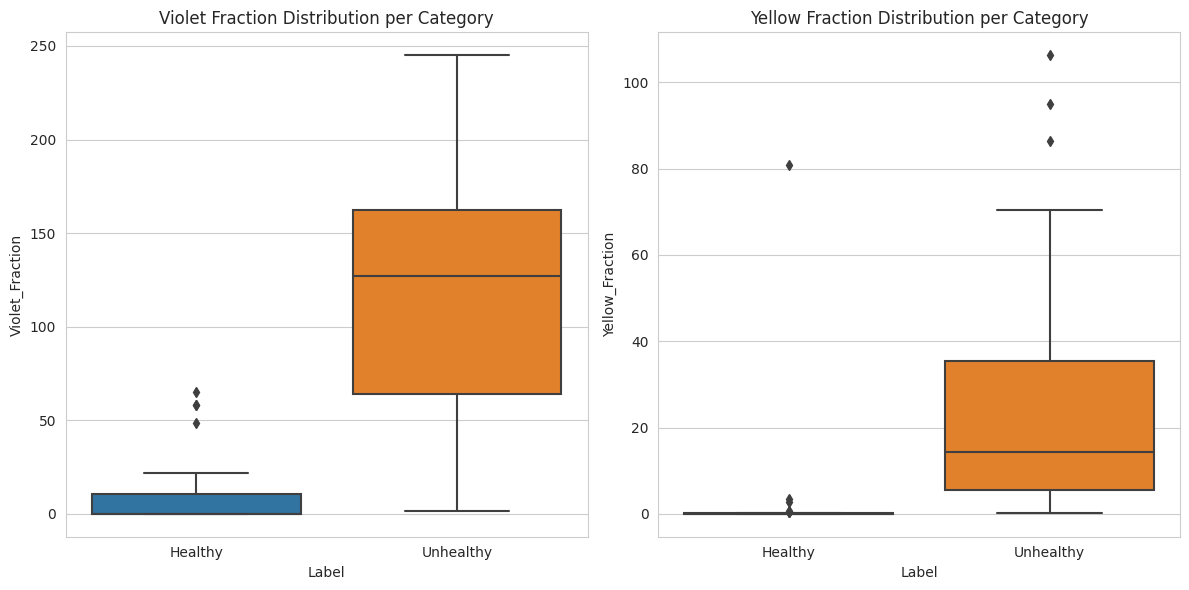

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y='Violet_Fraction', data=image_df)
plt.title('Violet Fraction Distribution per Category')
plt.subplot(1, 2, 2)
sns.boxplot(x='Label', y='Yellow_Fraction', data=image_df)
plt.title('Yellow Fraction Distribution per Category')

plt.tight_layout()
plt.show()

In [13]:
image_df['Filepath'].value_counts()

Filepath
../input/building-health/Healthy/FLIR_20230911_091339_262.jpg      1
../input/building-health/Unhealthy/FLIR_20230911_091531_593.jpg    1
../input/building-health/Unhealthy/FLIR_20230911_091726_403.jpg    1
../input/building-health/Unhealthy/FLIR_20230910_020918_375.jpg    1
../input/building-health/Unhealthy/FLIR_20230910_020445_334.jpg    1
                                                                  ..
../input/building-health/Healthy/FLIR_20230911_091114_745.jpg      1
../input/building-health/Healthy/FLIR_20230910_121720_156.jpg      1
../input/building-health/Healthy/FLIR_20230911_092003_502.jpg      1
../input/building-health/Healthy/FLIR_20230911_091939_586.jpg      1
../input/building-health/Unhealthy/FLIR_20230910_020507_896.jpg    1
Name: count, Length: 98, dtype: int64

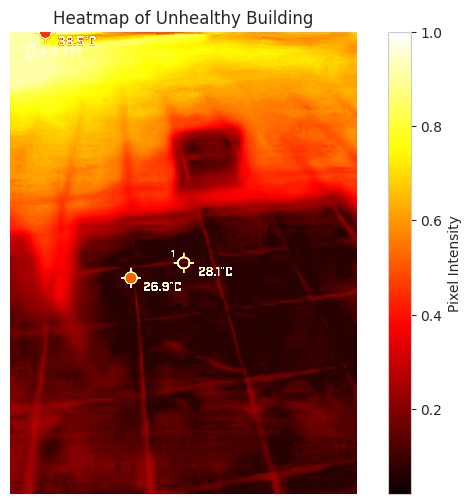

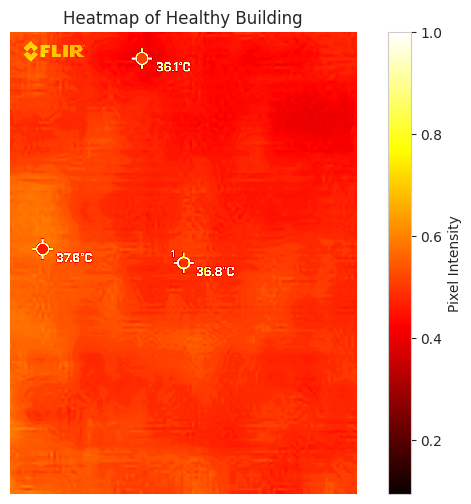

In [14]:
def plot_heatmap(image_path, title):
    img = Image.open(image_path)

    img_gray = img.convert('L')

    # Convert image to numpy array and normalize values to range [0, 1]
    data = np.asarray(img_gray) / 255.0

    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Pixel Intensity')
    plt.title(title)
    plt.axis('off')  
    plt.show()

image_unhealthy = "../input/building-health/Unhealthy/FLIR_20230911_091531_593.jpg"
image_healthy = "../input/building-health/Healthy/FLIR_20230911_091339_262.jpg"

plot_heatmap(image_unhealthy, 'Heatmap of Unhealthy Building')
plot_heatmap(image_healthy, 'Heatmap of Healthy Building')

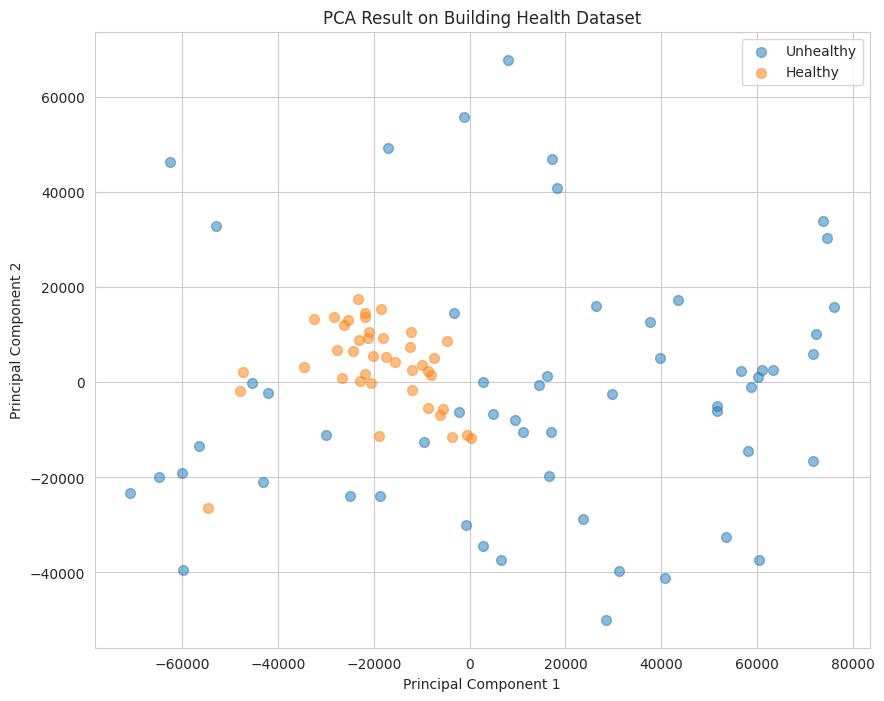

In [15]:
# Function to convert an image to a flattened array
def image_to_array(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    return np.array(img).flatten()

dir_unhealthy = "../input/building-health/Unhealthy/"
dir_healthy = "../input/building-health/Healthy/"

unhealthy_images = [dir_unhealthy + img for img in os.listdir(dir_unhealthy)]
healthy_images = [dir_healthy + img for img in os.listdir(dir_healthy)]

all_images = unhealthy_images + healthy_images

images_data = [image_to_array(path) for path in all_images]

labels = [0] * len(unhealthy_images) + [1] * len(healthy_images)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components
principal_components = pca.fit_transform(images_data)

plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0][np.array(labels) == 0], principal_components[:, 1][np.array(labels) == 0], s=50, alpha=0.5, label="Unhealthy")
plt.scatter(principal_components[:, 0][np.array(labels) == 1], principal_components[:, 1][np.array(labels) == 1], s=50, alpha=0.5, label="Healthy")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result on Building Health Dataset')
plt.legend()
plt.grid(True)
plt.show()


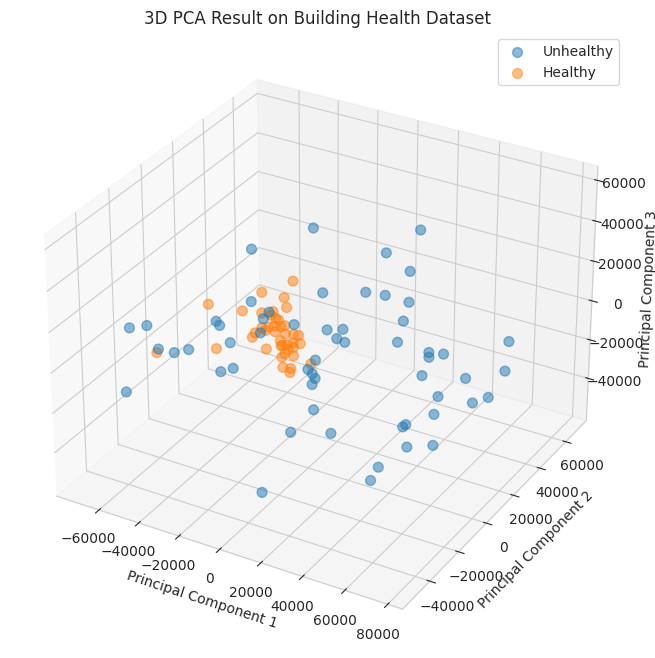

In [16]:
pca = PCA(n_components=3)  
principal_components = pca.fit_transform(images_data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principal_components[:, 0][np.array(labels) == 0], 
           principal_components[:, 1][np.array(labels) == 0], 
           principal_components[:, 2][np.array(labels) == 0], 
           s=50, alpha=0.5, label="Unhealthy")

ax.scatter(principal_components[:, 0][np.array(labels) == 1], 
           principal_components[:, 1][np.array(labels) == 1], 
           principal_components[:, 2][np.array(labels) == 1], 
           s=50, alpha=0.5, label="Healthy")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Result on Building Health Dataset')
ax.legend()
ax.grid(True)
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input

# Images Data Augmentation

In [10]:
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     zoom_range=0.2,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     horizontal_flip=True,
#     fill_mode="nearest",
#     validation_split=0.2
# )
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  
    zoom_range=0.15,  
    width_shift_range=0.15,  
    height_shift_range=0.15,  
    shear_range=0.15,  
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '../input/building-health/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '../input/building-health/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 79 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [109]:
# images, labels = next(train_generator)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))
# axes = axes.ravel()

# for i in range(16):
#     ax = axes[i]
#     ax.imshow(images[i].astype(int))
#     ax.set_title(f'Label: {labels[i]}')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

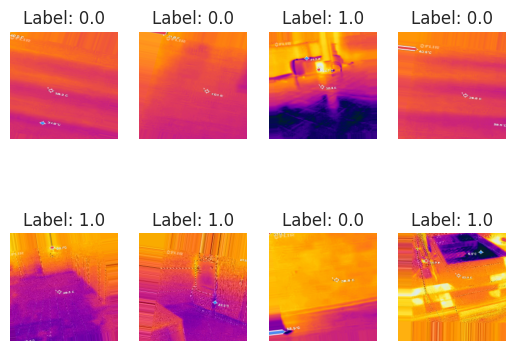

In [110]:
images, labels = next(train_generator)
images = images * 255

for i in range(8): # Change this number based on how many images you want to see
    plt.subplot(2, 4, i+1) # Adjust subplot params based on number of images
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

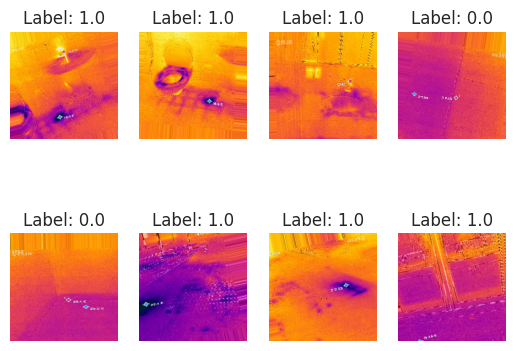

In [111]:
images, labels = next(validation_generator)
images = images * 255

for i in range(8): # Change this number based on how many images you want to see
    plt.subplot(2, 4, i+1) # Adjust subplot params based on number of images
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

# MobileNet model

In [165]:
# Construct the full model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dense(256, activation='relu'),  
#     Dropout(0.5), 
#     Dense(1, activation='sigmoid')  
# ])

def step_decay(epoch):
    initial_lr = 1e-4
    drop = 0.5
    epochs_drop = 5
    return initial_lr * (drop ** (epoch // epochs_drop))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weights_mobilenetv2.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(image_df['Label']),
                                            y=image_df['Label'].values)
class_weights = dict(enumerate(weights))

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, lr_scheduler]  
)

Epoch 1/10
3/3 [==============================] - 11s 1s/step - loss: 1.1305 - accuracy: 0.5570 - val_loss: 0.6786 - val_accuracy: 0.4211 - lr: 1.0000e-04
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.6737 - accuracy: 0.7089 - val_loss: 0.6605 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.6615 - accuracy: 0.6962 - val_loss: 0.6307 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.6276 - accuracy: 0.6835 - val_loss: 0.5813 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.3775 - accuracy: 0.8101 - val_loss: 0.5066 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 6/10
3/3 [==============================] - 3s 950ms/step - loss: 0.4644 - accuracy: 0.7722 - val_loss: 0.5247 - val_accuracy: 0.8421 - lr: 5.0000e-05
Epoch 7/10
3/3 [==============================] - 3s 924ms/step - loss: 

In [166]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

1/1 [==============================] - 1s 592ms/step - loss: 0.4436 - accuracy: 0.8421
Validation Accuracy: 84.21%


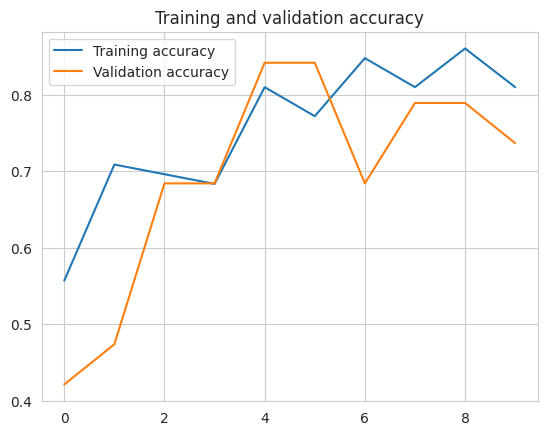

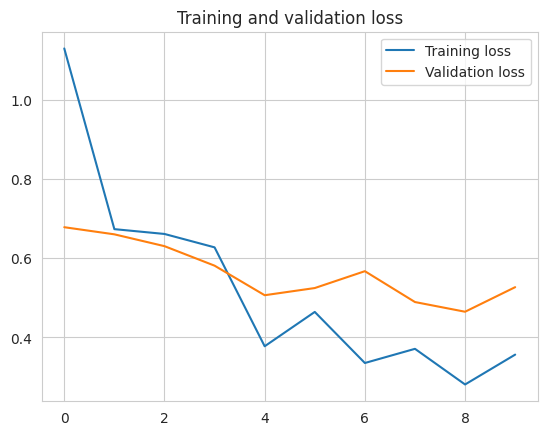

In [167]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [168]:
y_probabilities = model.predict(validation_generator)

# Check the predicted probabilities
for i, prob in enumerate(y_probabilities):
    print(f"Sample {i+1} - Predicted Probability: {prob}")


1/1 [==============================] - 1s 1s/step
Sample 1 - Predicted Probability: [0.57161415]
Sample 2 - Predicted Probability: [0.19270392]
Sample 3 - Predicted Probability: [0.3037394]
Sample 4 - Predicted Probability: [0.7594637]
Sample 5 - Predicted Probability: [0.5284399]
Sample 6 - Predicted Probability: [0.6756177]
Sample 7 - Predicted Probability: [0.45621333]
Sample 8 - Predicted Probability: [0.36480552]
Sample 9 - Predicted Probability: [0.5996569]
Sample 10 - Predicted Probability: [0.6987052]
Sample 11 - Predicted Probability: [0.6074548]
Sample 12 - Predicted Probability: [0.26206353]
Sample 13 - Predicted Probability: [0.49372238]
Sample 14 - Predicted Probability: [0.6631906]
Sample 15 - Predicted Probability: [0.18943803]
Sample 16 - Predicted Probability: [0.5772203]
Sample 17 - Predicted Probability: [0.1301004]
Sample 18 - Predicted Probability: [0.66074437]
Sample 19 - Predicted Probability: [0.1757996]


In [169]:
pred = model.predict(validation_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 1s 593ms/step
The first 5 predictions: ['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy']


1/1 [==============================] - 1s 572ms/step
              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.86      0.55      0.67        11

    accuracy                           0.68        19
   macro avg       0.72      0.71      0.68        19
weighted avg       0.74      0.68      0.68        19



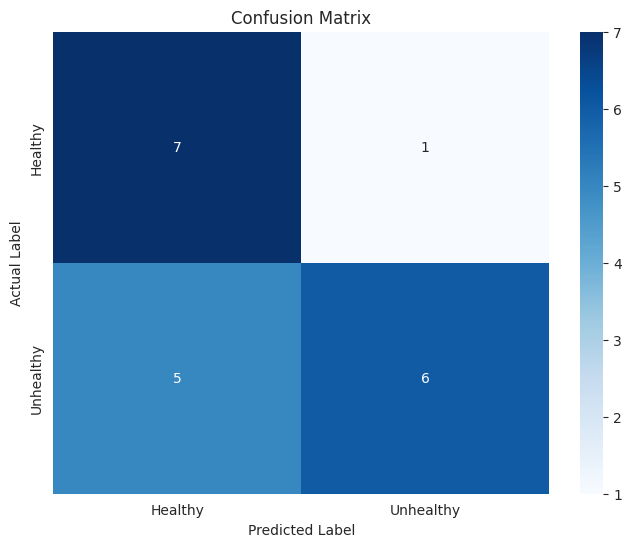

In [170]:
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred = np.where(predictions > 0.5, 1, 0)  # Use threshold of 0.5 for binary classification
y_true = validation_generator.classes

report = classification_report(y_true, y_pred)
print(report)

confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices,
            yticklabels=validation_generator.class_indices)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()